## [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing): ProPublica's analysis of the COMPAS tool

This workbook restates the initial data analysis tasks, per ProPublica's [methodology description](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) and [code](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb)

ProPublica's analysis was done in R, but we will do our same analysis in Python for the Lab

In [1]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import numpy as np

import math

import statsmodels.api as sm

### Acquiring the dataset, and understanding the data collection methodology.

Create a folder called "data" under the current folder, and download the COMPAS scores dataset.  The dataset is archived and is not expected to change.  Therefore, you can comment out this block if you already downloaded the data.

In [2]:
# Creates a folder "data" under the current folder
!mkdir -p data
# Removes any prior file if it exists
!rm -f data/compas-scores-two-years.csv*
# Fetches the most recent dataset and stores it under the folder data
!curl 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv' -o data/compas-scores-two-years.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2486k  100 2486k    0     0   185k      0  0:00:13  0:00:13 --:--:--  258k 0     0  98137      0  0:00:25  0:00:04  0:00:21 98263


Inspect the file.  Read the description of the [data collection methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).  Salient points are highlighted below, with my annotations in **bold font**.  See full description from ProPublica for additional details.  

>**Goal**: We looked at more than 10,000 criminal defendants in Broward County, Florida, and compared their predicted recidivism rates with the rate that actually occurred over a two-year period.

>**COMPAS tool input (data subjects)**: When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of *Risk of Recidivism* and *Risk of Violent Recidivism*

>**How COMPAS input was acquired by ProPublica**: Through a public records request, ProPublica obtained two years worth of COMPAS scores from the Broward County Sheriff’s Office in Florida. We received data for all 18,610 people who were scored in 2013 and 2014.

>**COMPAS tool output**: Each pretrial defendant received at least three COMPAS scores: “Risk of Recidivism,” “Risk of Violence” and “Risk of Failure to Appear. ... COMPAS scores for each defendant ranged from 1 to 10, with ten being the highest risk. Scores 1 to 4 were labeled by COMPAS as “Low”; 5 to 7 were labeled “Medium”; and 8 to 10 were labeled “High.”

>**Data integration (record linkage) to matching COMPAS input and output with an individual's criminal history** Starting with the database of COMPAS scores, we built a profile of each person’s criminal history, both before and after they were scored. We collected public criminal records from the Broward County Clerk’s Office website through April 1, 2016. On average, defendants in our dataset were not incarcerated for 622.87 days (sd: 329.19).

>**Data integration (record linkage) details**: We matched the criminal records to the COMPAS records using a person’s first and last names and date of birth. This is the same technique used in the Broward County COMPAS validation study conducted by researchers at Florida State University in 2010. We downloaded around 80,000 criminal records from the Broward County Clerk’s Office website.

>**What is recidivism?**: Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored. ... **For most of our analysis, we defined recidivism as a new arrest within two years. **

In [3]:
df_raw_data = pd.read_csv("data/compas-scores-two-years.csv")

In [4]:
df_raw_data.head(5)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [5]:
df_raw_data.shape

(7214, 53)

### Data profiling

Understand the statistical properties of the dataset.  

Here, we inspect the basic properties of the dataset: break-down by age, gender and race.

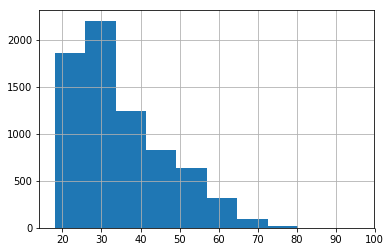

In [6]:
df_raw_data["age"].hist()

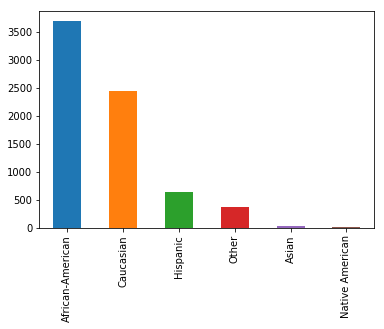

In [7]:
df_raw_data["race"].value_counts().plot(kind='bar')

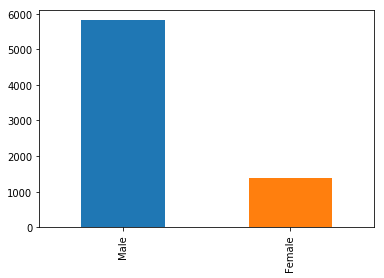

In [8]:
df_raw_data["sex"].value_counts().plot(kind='bar')

### Data cleaning

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.


In [9]:
# projection: keep a subset of the columns in the original dataset
df1 = df_raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]

print(df1.shape)

(7214, 13)


In [10]:
df1.head(5)

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
3,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0,NaN,NaN
4,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0,NaN,NaN


In [11]:
df2 = df1[(df_raw_data.c_charge_degree != 'O') & (df_raw_data.score_text != 'N/A') & (df_raw_data.is_recid != -1)
               & (df_raw_data.days_b_screening_arrest <= 30) & (df_raw_data.days_b_screening_arrest >= -30)]

print(df2.shape)

(6172, 13)


In [12]:
print('Original ', len(df_raw_data))
print('Projected ', len(df1))
print ('Cleaned ', len(df2))
df2.head()

Original  7214
Projected  7214
Cleaned  6172


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


### Data profiling, after data cleaning 

Look at basic properties of the dataset: break-down by age, gender and race.  Compare histograms before and after data cleaning.

Observe that we are going through the lifecycle **iteratively**: profile, clean, profile again.  

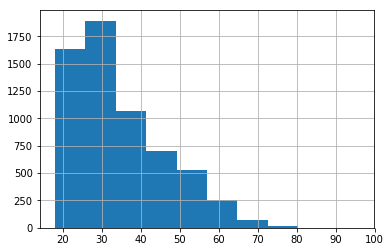

In [13]:
# visualize basic dataset statistics
df2["age"].hist()

### Data exploration

Are there differences in the distribution of risk scores by gender or race?



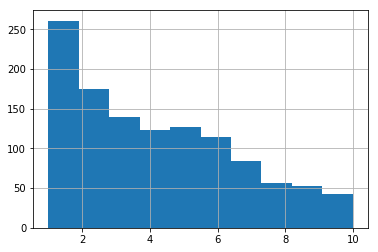

In [14]:
# compute score histograms by race and by gender 
df_f = df2[(df2.sex == 'Female')]
df_f["decile_score"].hist()

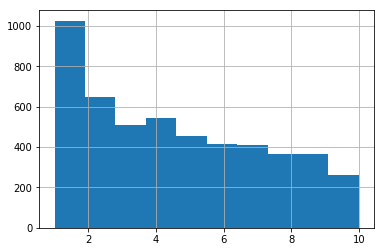

In [15]:
df_m = df2[(df2.sex == 'Male')]
df_m["decile_score"].hist()


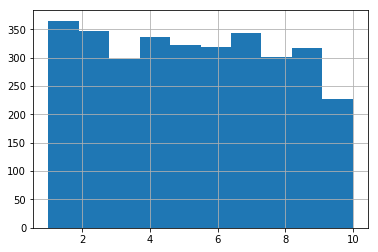

In [16]:
df_aa = df2[(df2.race == 'African-American')]
df_aa["decile_score"].hist()

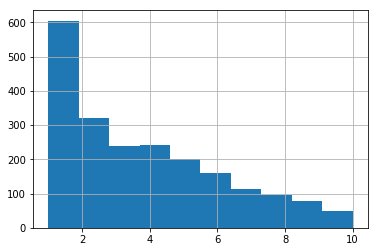

In [17]:
df_wh = df2[(df2.race == 'Caucasian')]
df_wh["decile_score"].hist()

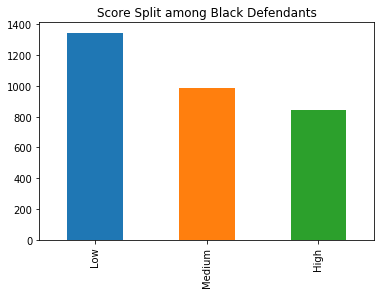

In [18]:
df_aa["score_text"].value_counts().plot(kind='bar', title = "Score Split among Black Defendants")

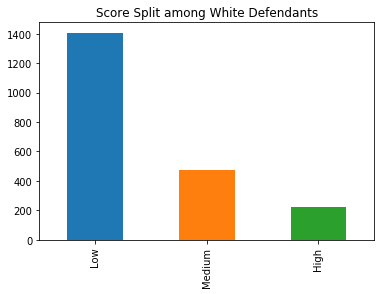

In [19]:
df_wh["score_text"].value_counts().plot(kind='bar', title = "Score Split among White Defendants")

In [20]:
df2['age_cat'].value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [21]:
df2['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

After filtering we have the following demographic breakdown:

In [22]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [23]:
df2['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [24]:
df2.pivot_table(values=['score_text'], columns=['race'], index=['sex'],aggfunc=lambda x: len(x))

score_text                                               
race   African-American Asian Caucasian Hispanic Native American Other
sex                                                                   
Female              549     2       482       82               2    58
Male               2626    29      1621      427               9   285

In [25]:
df2['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [26]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

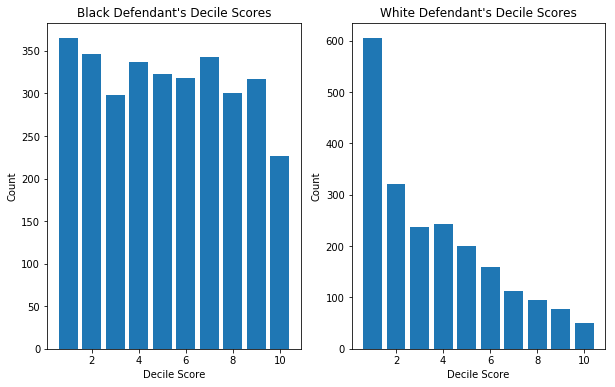

In [27]:
afr = df2[df2['race'] == "African-American"].groupby(df2['decile_score']).count()
cau = df2[df2['race'] == "Caucasian"].groupby(df2['decile_score']).count()

y_cau = list(cau['score_text'])
y_afr = list(afr['score_text'])
x = range(1,11)

fig = plt.figure(figsize=(10,6))
fig.add_subplot(121)
plt.bar(x, y_afr)
plt.xlabel('Decile Score')
plt.ylabel('Count')
plt.title("Black Defendant's Decile Scores")

fig.add_subplot(122)
plt.bar(x, y_cau)
plt.xlabel('Decile Score')
plt.ylabel('Count')
plt.title("White Defendant's Decile Scores")

# plt.tight_layout()
plt.show()

In [28]:
df2.pivot_table(values=['score_text'], columns=['race'], index=['decile_score'],aggfunc=lambda x: len(x))

score_text                                                
race         African-American Asian Caucasian Hispanic Native American  Other
decile_score                                                                 
1                       365.0  15.0     605.0    159.0             NaN  142.0
2                       346.0   4.0     321.0     89.0             2.0   60.0
3                       298.0   5.0     238.0     73.0             1.0   32.0
4                       337.0   NaN     243.0     47.0             NaN   39.0
5                       323.0   1.0     200.0     39.0             NaN   19.0
6                       318.0   2.0     160.0     27.0             2.0   20.0
7                       343.0   1.0     113.0     28.0             2.0    9.0
8                       301.0   2.0      96.0     14.0             NaN    7.0
9                       317.0   NaN      77.0     17.0             2.0    7.0
10                      227.0   1.0      50.0     16.0             2.0    8.0

## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into categorical variables and explode them using pandas dummies function, and run a logistic regression, comparing low scores to high scores.

Note: This is equivalent to applying factor to variables in R and then running a logistic regression.

In [29]:
df3 = df2.copy(deep=True)

df3['c_charge_degree'] = df3['c_charge_degree'].astype('category')
df3['age_cat'] = df3['age_cat'].astype('category')
df3['race'] = df3['race'].astype('category')
df3['sex'] = df3['sex'].astype('category')
df3['score_text'] = df3['score_text'].astype('category')

print(df3.dtypes)

age                           int64
c_charge_degree            category
race                       category
age_cat                    category
score_text                 category
sex                        category
priors_count                  int64
days_b_screening_arrest     float64
decile_score                  int64
is_recid                      int64
two_year_recid                int64
c_jail_in                    object
c_jail_out                   object
dtype: object


In [30]:
# explode c_charge_degree using get_dummies
dummies_c_charge_degree = pd.get_dummies(df3['c_charge_degree'])
df3 = pd.concat([df3, dummies_c_charge_degree], axis=1)
df3 = df3.drop(['c_charge_degree'], axis=1)

# age_cat
dummies_age_cat = pd.get_dummies(df3['age_cat'])
df3 = pd.concat([df3, dummies_age_cat], axis=1)

# Part of performing relevel after factor in R => Pro-Publica Analysis step
df3 = df3.drop(['age_cat', '25 - 45'], axis=1)

# race
dummies_race = pd.get_dummies(df3['race'])
df3 = pd.concat([df3, dummies_race], axis=1)
df3 = df3.drop(['race', 'Caucasian'], axis=1)

# sex
dummies_sex = pd.get_dummies(df3['sex'])
df3 = pd.concat([df3, dummies_sex], axis=1)
df3 = df3.drop(['sex', 'Male'], axis=1)


df3['score_text']= np.where(df3['score_text'] == "Low", "LowScore", df3['score_text'])

df3['score_text']= np.where(df3['score_text'] != "LowScore", "HighScore", df3['score_text'])

df3['score_text'] = df3['score_text'].astype('category')

In [31]:
df3 = df3.rename(columns={'African-American':'African_American', 'Greater than 45':'Greater_than_45', 'Less than 25':'Less_than_25', 'Native American':'Native_American'})

In [32]:
df3.dtypes

age                           int64
score_text                 category
priors_count                  int64
days_b_screening_arrest     float64
decile_score                  int64
is_recid                      int64
two_year_recid                int64
c_jail_in                    object
c_jail_out                   object
F                             uint8
M                             uint8
Greater_than_45               uint8
Less_than_25                  uint8
African_American              uint8
Asian                         uint8
Hispanic                      uint8
Native_American               uint8
Other                         uint8
Female                        uint8
dtype: object

In [33]:
df3.shape

(6172, 19)

In [34]:
df3.head(5)

,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,F,M,Greater_than_45,Less_than_25,African_American,Asian,Hispanic,Native_American,Other,Female
0,69,LowScore,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,1,0,1,0,0,0,0,0,1,0
1,34,LowScore,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,1,0,0,0,1,0,0,0,0,0
2,24,LowScore,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1,0,0,1,1,0,0,0,0,0
5,44,LowScore,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,0,1,0,0,0,0,0,0,1,0
6,41,HighScore,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,1,0,0,0,0,0,0,0,0,0


In [35]:
attributes = ['priors_count', 'two_year_recid', 'M', 'Greater_than_45',
       'Less_than_25', 'African_American', 'Asian', 'Hispanic',
       'Native_American', 'Other', 'Female']
target = ['score_text']

In [36]:
model = sm.formula.glm('score_text ~ priors_count + two_year_recid + M + Greater_than_45 + Less_than_25 + African_American + Asian + Hispanic + Native_American + Other + Female'
    , family=sm.families.Binomial(), data = df3).fit()
print(model.summary())


                                 Generalized Linear Model Regression Results                                 
Dep. Variable:     ['score_text[HighScore]', 'score_text[LowScore]']   No. Observations:                 6172
Model:                                                           GLM   Df Residuals:                     6160
Model Family:                                               Binomial   Df Model:                           11
Link Function:                                                 logit   Scale:                          1.0000
Method:                                                         IRLS   Log-Likelihood:                -3084.2
Date:                                               Mon, 28 Jan 2019   Deviance:                       6168.4
Time:                                                       17:51:17   Pearson chi2:                 6.07e+03
No. Iterations:                                                    6   Covariance Type:             nonrobust
          

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [37]:
control = math.exp(-1.52554) / (1 + math.exp(-1.52554))
math.exp(0.47721) / (1 - control + (control * math.exp(0.47721)))

1.4528408658138932

Women are 19.4% more likely than men to get a higher score.

In [38]:
math.exp(0.22127) / (1 - control + (control * math.exp(0.22127)))

1.1947978508506671

Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [39]:
math.exp(1.30839) / (1 - control + (control * math.exp(1.30839)))

2.4961202077189455

### Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [40]:
df_raw_violent_data = pd.read_csv('https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years-violent.csv')
df_raw_violent_data.shape


(4743, 54)

In [41]:
df_raw_violent_data.head(5)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


Just like before, let's do some Data Profiling before we move to Data Cleaning step

#### Data Profiling

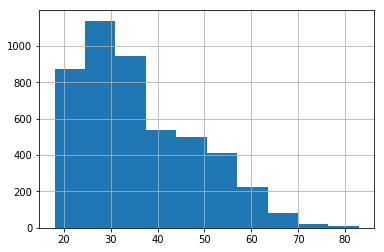

In [42]:
df_raw_violent_data["age"].hist()

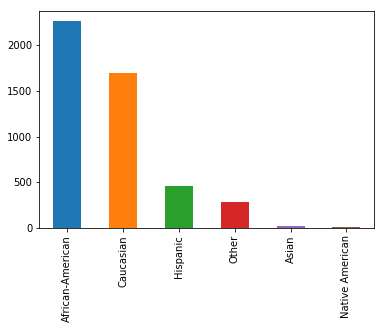

In [43]:
df_raw_violent_data["race"].value_counts().plot(kind='bar')

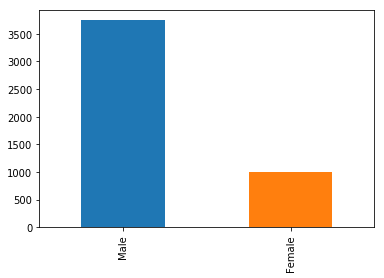

In [44]:
df_raw_violent_data["sex"].value_counts().plot(kind='bar')

#### Data Cleaning

In [45]:
# projection: keep a subset of the columns in the original dataset
df1_violent = df_raw_violent_data[['age', 'c_charge_degree', 'race', 'age_cat', 'v_score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'v_decile_score', 'is_recid', 'two_year_recid']]

print(df1_violent.shape)

(4743, 11)


In [47]:
# clean the data per ProPublica's methodology
df2_violent = df1_violent[(df1_violent.c_charge_degree != 'O') & (df1_violent.v_score_text != 'N/A') & (df1_violent.is_recid != -1)
               & (df1_violent.days_b_screening_arrest <= 30) & (df1_violent.days_b_screening_arrest >= -30)]

df2_violent.shape


(4020, 11)

In [48]:
print('Original ', len(df_raw_violent_data))
print('Projected ', len(df1_violent))
print ('Cleaned ', len(df2_violent))
df2.head()

Original  4743
Projected  4743
Cleaned  4020


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


#### Data Exploration

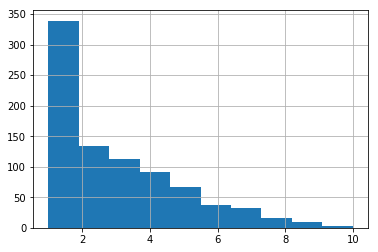

In [49]:
# compute score histograms by race and by gender 
df_f_violent = df2_violent[(df2_violent.sex == 'Female')]
df_f_violent["v_decile_score"].hist()

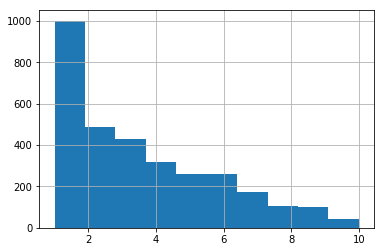

In [50]:
df_m_violent = df2_violent[(df2_violent.sex == 'Male')]
df_m_violent["v_decile_score"].hist()


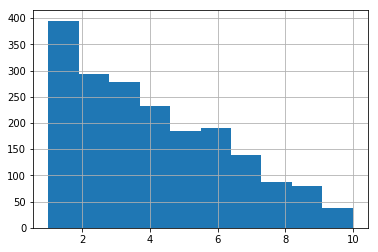

In [51]:
df_aa_violent = df2_violent[(df2_violent.race == 'African-American')]
df_aa_violent["v_decile_score"].hist()

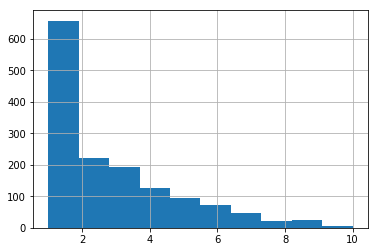

In [52]:
df_wh_violent = df2_violent[(df2_violent.race == 'Caucasian')]
df_wh_violent["v_decile_score"].hist()

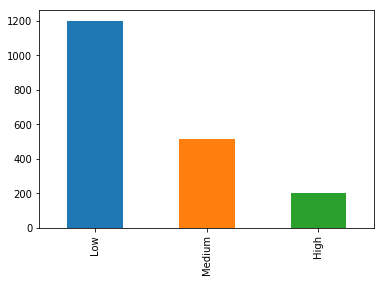

In [53]:
df_aa_violent["v_score_text"].value_counts().plot(kind='bar')

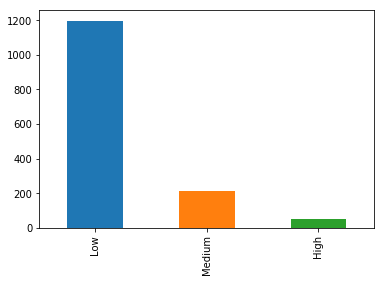

In [54]:
df_wh_violent["v_score_text"].value_counts().plot(kind='bar')

In [55]:
df2_violent['age_cat'].value_counts()

25 - 45            2300
Greater than 45     954
Less than 25        766
Name: age_cat, dtype: int64

In [56]:
df2_violent['race'].value_counts()

African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: race, dtype: int64

After filtering we have the following demographic breakdown:

In [57]:
print("Black defendants: %.2f%%" %            (1918 / 4020 * 100))
print("White defendants: %.2f%%" %            (1459 / 4020 * 100))
print("Hispanic defendants: %.2f%%" %         (355  / 4020 * 100))
print("Asian defendants: %.2f%%" %            (26   / 4020 * 100))
print("Native American defendants: %.2f%%" %  (7   / 4020 * 100))

Black defendants: 47.71%
White defendants: 36.29%
Hispanic defendants: 8.83%
Asian defendants: 0.65%
Native American defendants: 0.17%


In [58]:
df2_violent['v_score_text'].value_counts()

Low       2913
Medium     828
High       279
Name: v_score_text, dtype: int64

In [59]:
df2_violent.pivot_table(values=['v_score_text'], columns=['race'], index=['sex'],aggfunc=lambda x: len(x))

v_score_text                                                
race   African-American Asian Caucasian Hispanic Native American  Other
sex                                                                    
Female            393.0   1.0     336.0     61.0             NaN   50.0
Male             1525.0  25.0    1123.0    294.0             7.0  205.0

In [60]:
df2_violent['sex'].value_counts()

Male      3179
Female     841
Name: sex, dtype: int64

In [61]:
print("Men: %.2f%%" %   (3179 / 4020 * 100))
print("Women: %.2f%%" % (841 / 6172 * 100))

Men: 79.08%
Women: 13.63%


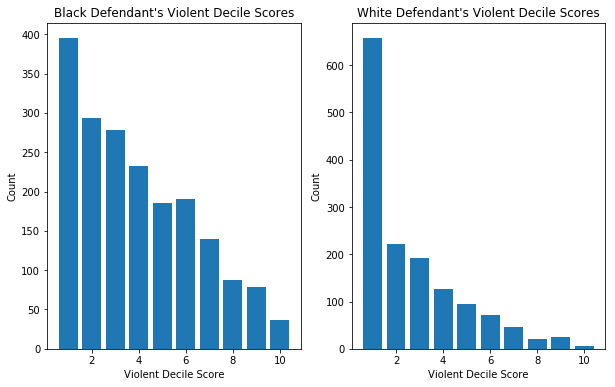

In [62]:
afr_violent = df2_violent[df2_violent['race'] == "African-American"].groupby(df2_violent['v_decile_score']).count()
cau_violent = df2_violent[df2_violent['race'] == "Caucasian"].groupby(df2_violent['v_decile_score']).count()

y_cau_violent = list(cau_violent['v_score_text'])
y_afr_violent = list(afr_violent['v_score_text'])
x = range(1,11)

fig = plt.figure(figsize=(10,6))
fig.add_subplot(121)
plt.bar(x, y_afr_violent)
plt.xlabel('Violent Decile Score')
plt.ylabel('Count')
plt.title("Black Defendant's Violent Decile Scores")

fig.add_subplot(122)
plt.bar(x, y_cau_violent)
plt.xlabel('Violent Decile Score')
plt.ylabel('Count')
plt.title("White Defendant's Violent Decile Scores")

# plt.tight_layout()
plt.show()

In [63]:
df3_violent = df2_violent.copy(deep=True)

df3_violent['c_charge_degree'] = df3_violent['c_charge_degree'].astype('category')
df3_violent['age_cat'] = df3_violent['age_cat'].astype('category')
df3_violent['race'] = df3_violent['race'].astype('category')
df3_violent['sex'] = df3_violent['sex'].astype('category')
df3_violent['v_score_text'] = df3_violent['v_score_text'].astype('category')

print(df3_violent.dtypes)

age                           int64
c_charge_degree            category
race                       category
age_cat                    category
v_score_text               category
sex                        category
priors_count                  int64
days_b_screening_arrest     float64
v_decile_score                int64
is_recid                      int64
two_year_recid                int64
dtype: object


In [64]:
# explode c_charge_degree using get_dummies
dummies_c_charge_degree = pd.get_dummies(df3_violent['c_charge_degree'])
df3_violent = pd.concat([df3_violent, dummies_c_charge_degree], axis=1)
df3_violent = df3_violent.drop(['c_charge_degree'], axis=1)

# age_cat
dummies_age_cat = pd.get_dummies(df3_violent['age_cat'])
df3_violent = pd.concat([df3_violent, dummies_age_cat], axis=1)

# Part of performing relevel after factor in R => Pro-Publica Analysis step
df3_violent = df3_violent.drop(['age_cat', '25 - 45'], axis=1)

# race
dummies_race = pd.get_dummies(df3_violent['race'])
df3_violent = pd.concat([df3_violent, dummies_race], axis=1)
df3_violent = df3_violent.drop(['race', 'Caucasian'], axis=1)

# sex
dummies_sex = pd.get_dummies(df3_violent['sex'])
df3_violent = pd.concat([df3_violent, dummies_sex], axis=1)
df3_violent = df3_violent.drop(['sex', 'Male'], axis=1)


df3_violent['v_score_text']= np.where(df3_violent['v_score_text'] == "Low", "LowScore", df3_violent['v_score_text'])

df3_violent['v_score_text']= np.where(df3_violent['v_score_text'] != "LowScore", "HighScore", df3_violent['v_score_text'])

df3_violent['v_score_text'] = df3_violent['v_score_text'].astype('category')


In [65]:
df3_violent = df3_violent.rename(columns={'African-American':'African_American', 'Greater than 45':'Greater_than_45', 'Less than 25':'Less_than_25', 'Native American':'Native_American'})


In [66]:
df3_violent.dtypes

age                           int64
v_score_text               category
priors_count                  int64
days_b_screening_arrest     float64
v_decile_score                int64
is_recid                      int64
two_year_recid                int64
F                             uint8
M                             uint8
Greater_than_45               uint8
Less_than_25                  uint8
African_American              uint8
Asian                         uint8
Hispanic                      uint8
Native_American               uint8
Other                         uint8
Female                        uint8
dtype: object

In [67]:
df3_violent.shape

(4020, 17)

In [68]:
df3_violent.head(5)

,age,v_score_text,priors_count,days_b_screening_arrest,v_decile_score,is_recid,two_year_recid,F,M,Greater_than_45,Less_than_25,African_American,Asian,Hispanic,Native_American,Other,Female
0,69,LowScore,0,-1.0,1,0,0,1,0,1,0,0,0,0,0,1,0
1,34,LowScore,0,-1.0,1,1,1,1,0,0,0,1,0,0,0,0,0
4,44,LowScore,0,0.0,1,0,0,0,1,0,0,0,0,0,0,1,0
5,43,LowScore,3,-1.0,3,0,0,1,0,0,0,0,0,0,0,1,0
6,39,LowScore,0,-1.0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [69]:
attributes = ['priors_count', 'two_year_recid', 'M', 'Greater_than_45',
       'Less_than_25', 'African_American', 'Asian', 'Hispanic',
       'Native_American', 'Other', 'Female']
target = ['v_score_text']

In [70]:
model_violent = sm.formula.glm('v_score_text ~ priors_count + two_year_recid + M + Greater_than_45 + Less_than_25 + African_American + Asian + Hispanic + Native_American + Other + Female'
    , family=sm.families.Binomial(), data = df3_violent).fit()
print(model_violent.summary())


                                   Generalized Linear Model Regression Results                                   
Dep. Variable:     ['v_score_text[HighScore]', 'v_score_text[LowScore]']   No. Observations:                 4020
Model:                                                               GLM   Df Residuals:                     4008
Model Family:                                                   Binomial   Df Model:                           11
Link Function:                                                     logit   Scale:                          1.0000
Method:                                                             IRLS   Log-Likelihood:                -1499.4
Date:                                                   Mon, 28 Jan 2019   Deviance:                       2998.8
Time:                                                           17:54:23   Pearson chi2:                 3.83e+03
No. Iterations:                                                        6   Covariance Ty

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

In [71]:
control = math.exp(-2.24274) / (1 + math.exp(-2.24274))
math.exp(0.65893) / (1 - control + (control * math.exp(0.65893)))

1.7739209589164604

Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [72]:
math.exp(3.14591) / (1 - control + (control * math.exp(3.14591)))

7.414239863565466